# 1. Preprocessing

### Reading the dataset

In [51]:
import pandas as pd
df = pd.read_csv('train_lyrics_1000.csv')
df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


### Label Encoder


In [52]:
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

X_train = df['lyrics'].values 
y_train = df['mood'].values

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train[:5])

before: ['sad' 'happy' 'sad' 'happy' 'sad'] ...
after: [1 0 1 0 1] ...


In [53]:
# Save object to disk
import pickle

pickle_out = open('lyrics_label_encoder_py.pkl', 'wb')
pickle.dump(le, pickle_out)
pickle_out.close()

### Feature extraction: Word counts and Vectorizers

### a) Porter Stemmer

In [54]:
# Porter Stemmer
import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

### b)Stop word list

In [55]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
 
stop_words = set(stopwords.words('english'))
#print('stop words %s ...' %stop_words[:5])

### c) Count Vectorizer

In [56]:
# Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(1,1)
    )

Fitting the lyrics

In [57]:
vec = vec.fit(X_train.ravel())

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [58]:
print('Vocabulary size: %s' %len(vec.get_feature_names()))

Vocabulary size: 8528


### d)Tfidf Vectorizer

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer
    )

Fitting the lyrics

In [60]:
tfidf = tfidf.fit(X_train.ravel())

print('Vocabulary size: %s' %len(tfidf.get_feature_names()))

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Vocabulary size: 8528


# 2. Model Selection

## Grid search and hyperparameter tuning

MODELS:

KNeighborsClassifier       ---> Classifier implementing the k-nearest neighbors vote 

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

Performance metric: F1-score

In [62]:
# Custom scorer methods to account for positive-negative class labels
from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)

### a) Grid Search


In [63]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

pipeline_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', KNeighborsClassifier(n_neighbors=2))
])

parameters_1 = dict(
    vect__binary=[True],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_1 = GridSearchCV(pipeline_1, 
                           parameters_1, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search for KNeighborsClassifier ... ")
print("pipeline:", [name for name, _ in pipeline_1.steps])
print("parameters:")
pprint(parameters_1, depth=2)
grid_search_1.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_1.best_score_)
print("Best parameters set:")
best_parameters_1 = grid_search_1.best_estimator_.get_params()
for param_name in sorted(parameters_1.keys()):
    print("\t%s: %r" % (param_name, best_parameters_1[param_name]))

Performing grid search for KNeighborsClassifier ... 
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [True],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [{'a',
                       'about',
                       'above',
                       'after',
                       'again',
                       'against',
                       'ain',
                       'all',
                       'am',
                       'an',
                       'and',
                       'any',
                       'are',
                       'aren',
                       "aren't",
                       'as',
                       'at',
                       'be',
                       'because',
                       'been',
                       'before',
                       'being',
                       'below',
                       'between',
                       'both',
                       'but',
                       'by',
    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklear

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\

Best score: 0.499
Best parameters set:
	vect__binary: True
	vect__ngram_range: (1, 1)
	vect__stop_words: None
	vect__tokenizer: <function porter_tokenizer at 0x000001D6C5406AE8>


### b)Grid Search ROC Curves

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


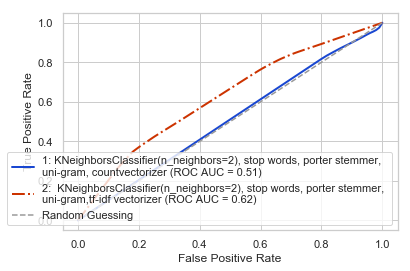

In [64]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

clf_1 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=True,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', KNeighborsClassifier(n_neighbors=2)),
                 ])


clf_2 = Pipeline([
                  ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', KNeighborsClassifier(n_neighbors=2)),
                 ])

colors = ['#1947D1', '#CC3300']
linestyles = ['-',  '-.']
classifiers = [clf_1, clf_2, ]
labels = ['1: KNeighborsClassifier(n_neighbors=2), stop words, porter stemmer, \nuni-gram, countvectorizer', 
          '2:  KNeighborsClassifier(n_neighbors=2), stop words, porter stemmer, \nuni-gram,tf-idf vectorizer',
          ]

for clf,col,ls,lab in zip(classifiers, colors, linestyles, labels):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv=StratifiedKFold( n_splits=10, random_state=123 )
    c =cv.n_splits
    
    for i, (train, test) in enumerate(cv.split(X_train,y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= c
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('roc_gridsearch_1.eps', dpi=300)
plt.show()

### c) Hyperparameter tuning 1 - max_features


C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsisten

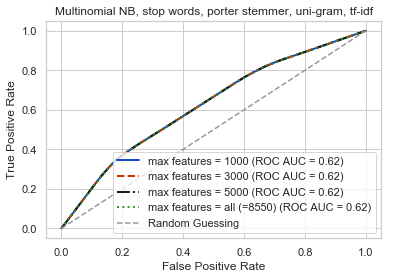

In [65]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', '#339933']
linestyles = ['-', '--', '-.', ':']
params = [1000,3000,5000,None]
labels = ['max features = 1000', 
          'max features = 3000',
          'max features = 5000',
          'max features = all (=8550)',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                  ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', KNeighborsClassifier(n_neighbors=2)),
                 ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv=StratifiedKFold( n_splits=10, random_state=123 )
    c =cv.n_splits


    for i, (train, test) in enumerate(cv.split(X_train,y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= c
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.legend(loc="lower right")
plt.savefig('roc_maxfeatures.eps', dpi=300)
plt.show()

### d) Hyperparameter tuning 2 - min_df


C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsisten

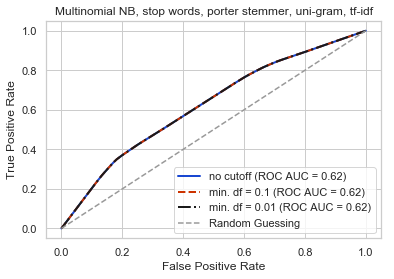

In [66]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', ]
linestyles = ['-', '--', '-.']
params = [1, 0.1, 0.01]
labels = ['no cutoff',
          'min. df = 0.1', 
          'min. df = 0.01',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                  ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', KNeighborsClassifier(n_neighbors=2)),
                 ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    cv=StratifiedKFold( n_splits=10, random_state=123 )
    c =cv.n_splits

    for i, (train, test) in enumerate(cv.split(X_train,y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= c

    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.savefig('roc_mindf.eps', dpi=300)
plt.show()

### f) n-gram comparison

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsisten

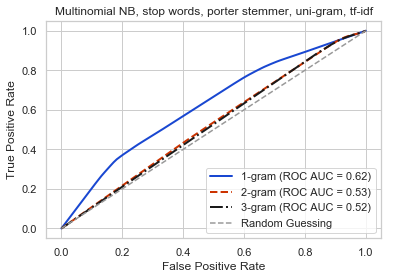

In [68]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', ]
linestyles = ['-', '--', '-.',]
params = [(1,1), (2,2), (3,3),]
labels = ['1-gram', 
          '2-gram',
          '3-gram',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=param,
                                                  
                                                  )
                          ),
                         ('clf', KNeighborsClassifier(n_neighbors=2)),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = [] 

    cv=StratifiedKFold( n_splits=10, random_state=123 )
    c =cv.n_splits

    for i, (train, test) in enumerate(cv.split(X_train,y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= c
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.savefig('roc_ngrams.eps', dpi=300)
plt.show()

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


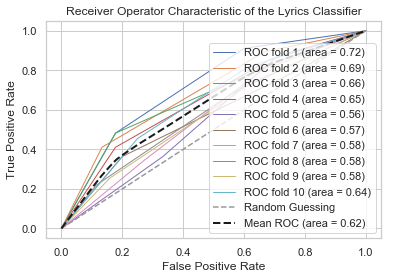

In [69]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

classifier = Pipeline([
               ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', KNeighborsClassifier(n_neighbors=2)),
              ])

cv=StratifiedKFold( n_splits=10, random_state=123 )
c =cv.n_splits


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv.split(X_train,y_train)):
    probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')

mean_tpr /= c
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic of the Lyrics Classifier')
plt.legend(loc="lower right")
plt.savefig('imagroc_final.eps', dpi=300)
plt.show()

#  3) Validation

In [71]:
final_clf = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         tokenizer=porter_tokenizer,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', KNeighborsClassifier(n_neighbors=2)),
               ])
final_clf.fit(X_train, y_train)

C:\Users\HarshithaGS\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...ki',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform'))])

### a) Confusion matrix


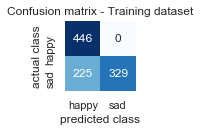

In [72]:
import matplotlib as mpl
import numpy as np

cm = metrics.confusion_matrix(y_train, final_clf.predict(X_train))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Training dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('confmat_training.eps', dpi=300)
plt.show()

In [73]:
df = pd.read_csv('valid_lyrics_200.csv')

X_valid = df['lyrics'].values 
y_valid = df['mood'].values

y_valid = le.transform(y_valid)

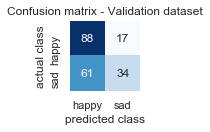

In [74]:
cm = metrics.confusion_matrix(y_valid, final_clf.predict(X_valid))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('confmat_valid.eps', dpi=300)
plt.show()

### b) ROC AUC, Accuracy, Precision, Recall, and F1-score

In [75]:
# Custom scorer methods to account for positive-negative class labels

from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label=0)
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label=0)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [76]:
d = {'Data':['Training', 'Validation'],
     'ACC (%)':[],
     'PRE (%)':[],
     'REC (%)':[],
     'F1 (%)':[],
     'ROC AUC (%)':[],
}

In [77]:
d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_train, y_true=y_train))

d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))

In [78]:
df_perform = pd.DataFrame(d)
df_perform = df_perform[['ACC (%)', 'PRE (%)', 'REC (%)', 'F1 (%)', 'ROC AUC (%)']]
df_perform.index=(['Training', 'Validation'])
df_perform = df_perform*100
df_perform = np.round(df_perform, decimals=2)
df_perform

,ACC (%),PRE (%),REC (%),F1 (%),ROC AUC (%)
Training,77.5,66.47,100.00,79.86,79.69
Validation,61.0,59.06,83.81,69.29,59.80


In [79]:
df_perform.to_csv('clf_performance.csv', index_label=False)

# 4) Save classifier


In [80]:
lyrics_clf_1000 = final_clf

pickle_out = open('lyrics_clf_1000_py27.pkl', 'wb')
pickle.dump(lyrics_clf_1000, pickle_out)
pickle_out.close()

### New pickle objects for webapp

In [81]:
import pickle

pickle_out = open('lyrics_label_encoder_py.pkl', 'rb')
le = pickle.load(pickle_out)
pickle_out.close()

In [83]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
 
stop_words = set(stopwords.words('english'))

In [84]:
# Porter Stemmer

import nltk
import string
import re


porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

In [85]:
import pandas as pd
df = pd.read_csv('train_lyrics_1000.csv')
X_train = df['lyrics'].values 
y_train = df['mood'].values

In [86]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer



final_clf = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', KNeighborsClassifier(n_neighbors=2)),
               ])
final_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...ki',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform'))])

In [88]:
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline

import pickle

pickle_out = open('lyrics_label_encoder_np.pkl', 'wb')
pickle.dump(le, pickle_out)
pickle_out.close()

joblib.dump(final_clf, 'lyrics_clf_1000_np.pkl')

['lyrics_clf_1000_np.pkl']

In [89]:
from sklearn.externals import joblib

final_clf = joblib.load('lyrics_clf_1000_np.pkl')

In [90]:
final_clf.predict(X_train)[:3]

array([1, 0, 0])

In [91]:
joblib.dump(le, 'lyrics_label_encoder_jb.pkl')

['lyrics_label_encoder_jb.pkl']

In [92]:
from sklearn.externals import joblib
lyrics_label_encoder = joblib.load('lyrics_label_encoder_jb.pkl')